## Training a GPT-2 model

[Theis et al. (2016)](https://arxiv.org/abs/1511.01844) show that the (negative) log-likelihood (which is used to train many machine learning models) is not a sufficient criteria to decide whether a model training should terminate. Thus, in this notebook, we show how to use seqme's metrics to determine model training stopping criteria.



In [1]:
%load_ext autoreload
%autoreload 2

import random
from functools import partial
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments

import seqme as sm

import sklearn

import matplotlib as mpl
import matplotlib.gridspec as gridspec


#from notebooks.tokenizer import Tokenizer
from tokenizer import Tokenizer


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
set_seed(42)

In [4]:
WORKDIR_PATH = Path("./..")
#WORKDIR_PATH = Path("./")

## Setup

In [5]:
MODALITY = "molecules"

### Peptides

In [6]:
# !pip install datasets transformers[torch] "seqme[hyformer]==0.3.7" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@v2.0"

In [7]:
if MODALITY == "peptides":
    DATA_PATH = WORKDIR_PATH / "data" / "uniprot_8_50_100.fasta"
    VOCAB_PATH = WORKDIR_PATH / "configs" / "amino_acids_vocab.txt"

    MAX_LENGTH = 52
    BATCH_SIZE = 256
    NUM_TRAIN_EPOCHS = 300

    sequences = sm.read_fasta(DATA_PATH)
    sequences = sm.utils.subsample(sequences, n_samples=300_000)
    train, val = sklearn.model_selection.train_test_split(sequences, train_size=0.99)

    tokenizer = Tokenizer(
        regex_pattern=r""""A|C|D|E|F|G|H|I|K|L|M|N|P|Q|R|S|T|V|W|Y""",
        vocab_filepath=VOCAB_PATH,
        bos_token="[BOS]",
        eos_token="[EOS]",
        pad_token="[PAD]",
        unk_token="[UNK]",
        mask_token="[MASK]",
    )

    embedder_name = "Hyformer"
    embedder = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M)

### Small molecule

Data is from [here](https://figshare.com/projects/GuacaMol/56639).

In [8]:
# !pip install datasets transformers[torch] "seqme[hyformer_molecules]==0.3.7" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@main"

In [9]:
if MODALITY == "molecules":
    DATA_PATH = WORKDIR_PATH / "data" / "guacamol_v1_all.smiles"
    VOCAB_PATH = WORKDIR_PATH / "configs" / "guacamol_vocab.txt"

    MAX_LENGTH = 130
    BATCH_SIZE = 512
    NUM_TRAIN_EPOCHS = 400

    with open(DATA_PATH) as f:
        sequences = f.read().strip().split("\n")

    sequences = sm.utils.subsample(sequences, n_samples=300_000)
    train, val = sklearn.model_selection.train_test_split(sequences, train_size=0.99)

    tokenizer = Tokenizer(
        regex_pattern=r"""(\[[^\]]+\]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|%[0-9]{2}|[0-9])""",
        vocab_filepath=VOCAB_PATH,
        bos_token="[BOS]",
        eos_token="[EOS]",
        pad_token="[PAD]",
        unk_token="[UNK]",
        mask_token="[MASK]",
    )

    embedder_name = "Hyformer"
    embedder = sm.models.Hyformer(sm.models.HyformerCheckpoint.molecules_50M)

No normalization for SPS. Feature removed!


No normalization for AvgIpc. Feature removed!


No normalization for NumAmideBonds. Feature removed!


No normalization for NumAtomStereoCenters. Feature removed!


No normalization for NumBridgeheadAtoms. Feature removed!


No normalization for NumHeterocycles. Feature removed!


No normalization for NumSpiroAtoms. Feature removed!


No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!


No normalization for Phi. Feature removed!


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'


Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_repo_env/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'


Skipped loading some Jax models, missing a dependency. No module named 'jax'


Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Model state_dict loaded with strict=True.


### DNA

Data is from [here](https://zenodo.org/records/10184648).

In [10]:
# !pip install datasets transformers[torch] "seqme[genalm]==0.3.7"

In [11]:
if MODALITY == "dna_flybrain":
    #DATA_PATH = WORKDIR_PATH / "data" / "flybrain_data.pkl"
    DATA_PATH = WORKDIR_PATH / "data" / "melanoma_data.pkl"

    VOCAB_PATH = WORKDIR_PATH / "configs" / "dna_vocab.txt"

    MAX_LENGTH = 512
    BATCH_SIZE = 256
    NUM_TRAIN_EPOCHS = 200

    sequences = sm.read_pickle(DATA_PATH)
    train = torch.from_numpy(sequences["train_data"].argmax(axis=-1))
    val = torch.from_numpy(sequences["valid_data"].argmax(axis=-1))

    tokenizer = Tokenizer(
        regex_pattern=r"""A|T|G|C""",
        vocab_filepath=VOCAB_PATH,
        bos_token="[BOS]",
        eos_token="[EOS]",
        pad_token="[PAD]",
        unk_token="[UNK]",
        mask_token="[MASK]",
    )

    train = tokenizer.batch_decode(train)
    val = tokenizer.batch_decode(val)

    embedder_name = "GENA-LM"
    embedder = sm.models.GENALM(sm.models.GENALMCheckpoint.bert_base_t2t)

In [12]:
len(train), len(val)

(297000, 3000)

## Training

In [13]:
def collate_batch(batch, pad_id=tokenizer.pad_token_id, max_len=MAX_LENGTH):
    input_ids = [x["input_ids"][:max_len] for x in batch]
    labels = input_ids

    max_batch_len = max(len(x) for x in input_ids)
    input_ids = [x + [pad_id] * (max_batch_len - len(x)) for x in input_ids]
    labels = [x + [-100] * (max_batch_len - len(x)) for x in labels]

    attention_mask = [[1] * len(x) + [0] * (max_batch_len - len(x)) for x in input_ids]

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
    }


In [14]:
@torch.inference_mode()
def generate(
    model,
    n_samples: int,
    *,
    max_length=MAX_LENGTH,
    top_k: int = 5,
    top_p: float = 0.9,
    batch_size: int = 256,
) -> list[str]:
    BOS_ID = tokenizer.bos_token_id
    PAD_ID = tokenizer.pad_token_id
    input_ids = torch.tensor(
        [[BOS_ID]] * n_samples, dtype=torch.long, device=model.device
    )

    output = []
    for i in range(0, n_samples, batch_size):
        batch = input_ids[i : i + batch_size]
        output_ids = model.generate(
            input_ids=batch,
            max_length=max_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=PAD_ID,
        )
        output += tokenizer.batch_decode(output_ids)

    return output


In [15]:
dataset_train = Dataset.from_dict({"text": train})
dataset_valid = Dataset.from_dict({"text": val})
dataset = DatasetDict({"train": dataset_train, "validation": dataset_valid})

tokenized_dataset = dataset.map(
    tokenizer, remove_columns=["text"], batched=True, input_columns=["text"]
)

Map:   0%|          | 0/297000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [16]:
model = GPT2LMHeadModel(
    GPT2Config(
        vocab_size=tokenizer.vocab_size,
        n_positions=MAX_LENGTH,
        n_embd=256,
        n_layer=4,
        n_head=4,
    )
)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print(
    "Trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

Total parameters: 3220224
Trainable parameters: 3220224


In [17]:
n_sequences = 4096
dfs = []

cache = sm.Cache(models={embedder_name: embedder})
cached_embedder = cache.model(embedder_name)

metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.FBD(val, cached_embedder),
    sm.metrics.MMD(val, cached_embedder, device="cuda"),
    sm.metrics.Recall(
        n_neighbors=5,
        reference=val,
        embedder=cached_embedder,
        strict=False,
        device="cuda",
    ),
    sm.metrics.Precision(
        n_neighbors=5,
        reference=val,
        embedder=cached_embedder,
        strict=False,
        device="cuda",
    ),
]


def compute_metrics(eval_pred):
    sequences = partial(generate, model)(n_sequences)

    row_name = ("GPT-2", len(dfs))
    df = sm.evaluate({row_name: sequences}, metrics, verbose=False)
    dfs.append(df)

    return {
        f"val/{metric.name}": df[(metric.name, "value")][row_name] for metric in metrics
    }

In [ ]:
training_args = TrainingArguments(
    output_dir=WORKDIR_PATH / f"{MODALITY}_gpt2_small",
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=5e-4,
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="epoch",
    logging_steps=250,
    report_to="none",
    torch_compile=True,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collate_batch,
    compute_metrics=compute_metrics,
)

trainer.train()


## Evaluation

In [19]:
sm.to_pickle(trainer.state.log_history, WORKDIR_PATH / f"{MODALITY}_loss.pkl")

In [20]:
df_all = sm.combine(dfs)

sm.to_pickle(df_all, WORKDIR_PATH / f"{MODALITY}_seqme.pkl")

In [21]:
history = sm.read_pickle(WORKDIR_PATH / f"{MODALITY}_loss.pkl")

In [22]:
train_loss = [
    (dv["epoch"], dv["loss"]) for dv in history if "loss" in dv
]
val_loss = [
    (dv["epoch"], dv["eval_loss"])
    for dv in history
    if "eval_loss" in dv
]

train_steps, train_values = zip(*train_loss, strict=True)
val_steps, val_values = zip(*val_loss, strict=True)

In [23]:
df_all = sm.read_pickle(WORKDIR_PATH / f"{MODALITY}_seqme.pkl")

In [24]:
df_all.index = pd.MultiIndex.from_arrays([df_all.index.get_level_values(0), val_steps])

In [25]:
def insert(
    df: pd.DataFrame,
    name: str,
    values: np.ndarray,
    objective: Literal["minimize", "maximize"],
) -> pd.DataFrame:
    df = df.copy()
    df[(name, "value")] = values
    df[(name, "deviation")] = float("nan")
    df.attrs["objective"][name] = objective
    return df

In [26]:
df_all = insert(df_all, "Perplexity", np.exp(val_values), "minimize")

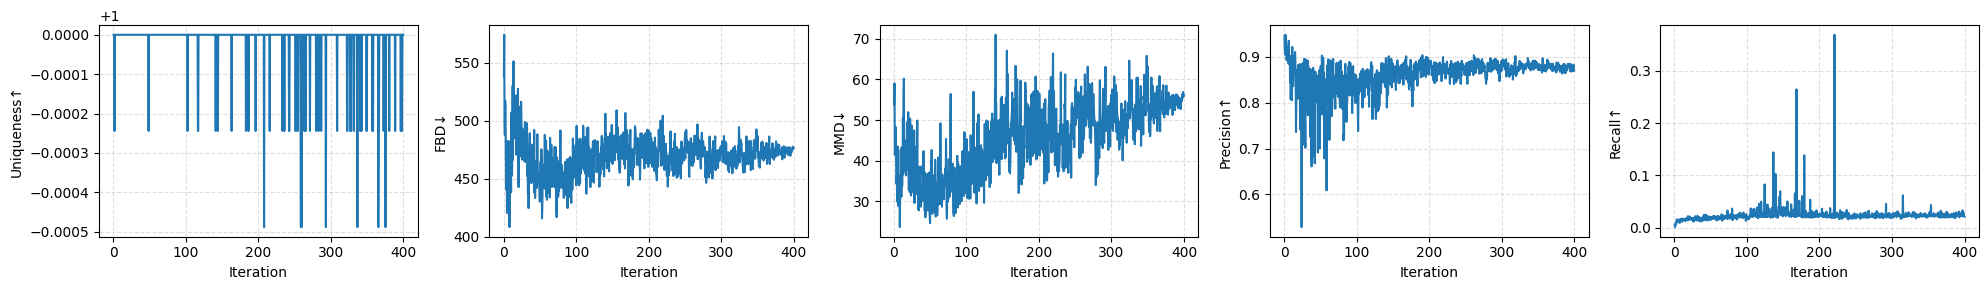

In [27]:
metrics_to_show = ["Uniqueness", "FBD", "MMD", "Precision", "Recall"]

fig, axes = plt.subplots(
    nrows=1, ncols=len(metrics_to_show), figsize=(len(metrics_to_show) * 4, 3)
)

for i, name in enumerate(metrics_to_show):
    sm.plot_line(df_all, metric=name, ax=axes[i], marker=None)
    axes[i].get_legend().remove()

fig.tight_layout()

In [28]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(df_all) - 1)) for i in range(len(df_all))]

df_flat = df_all.xs("GPT-2", level=0)

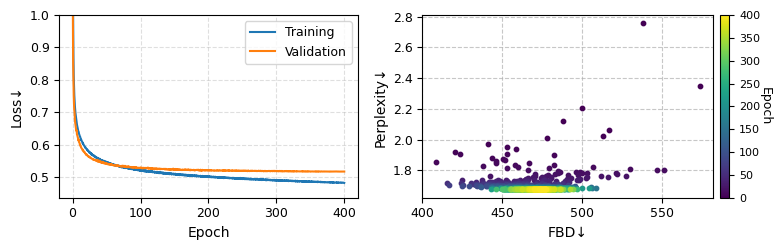

In [29]:
fig = plt.figure(figsize=(8, 2.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.46, 0.54])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

## loss
ax = ax0

ax.plot(train_steps, train_values, label="Training")
ax.plot(val_steps, val_values, label="Validation")
ax.tick_params(axis="both", labelsize=9)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss↓")
ax.legend(fontsize=9)
ax.grid(True, linestyle="--", alpha=0.4)
ax.set_ylim(top=1.0)

## trade-off
ax = ax1

sm.plot_scatter(df_flat, ["FBD", "Perplexity"], marker_size=10, ax=ax, color=colors)
ax.get_legend().remove()
ax.tick_params(axis="both", labelsize=9)

norm = mpl.colors.Normalize(vmin=0, vmax=NUM_TRAIN_EPOCHS)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, pad=0.02)
cbar.set_label("Epoch", rotation=270, va="center", fontsize=9)
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()
fig.savefig(WORKDIR_PATH / f"figs/case2/{MODALITY}_loss_fbd.png", bbox_inches="tight", dpi=300)

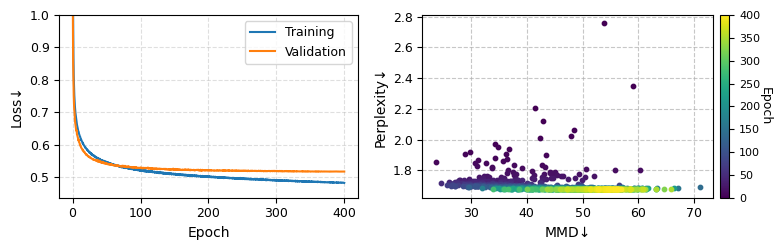

In [30]:
fig = plt.figure(figsize=(8, 2.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.46, 0.54])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

## loss
ax = ax0

ax.plot(train_steps, train_values, label="Training")
ax.plot(val_steps, val_values, label="Validation")
ax.tick_params(axis="both", labelsize=9)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss↓")
ax.legend(fontsize=9)
ax.grid(True, linestyle="--", alpha=0.4)
ax.set_ylim(top=1.0)

## trade-off
ax = ax1

sm.plot_scatter(df_flat, ["MMD", "Perplexity"], marker_size=10, ax=ax, color=colors)
ax.get_legend().remove()
ax.tick_params(axis="both", labelsize=9)

norm = mpl.colors.Normalize(vmin=0, vmax=NUM_TRAIN_EPOCHS)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, pad=0.02)
cbar.set_label("Epoch", rotation=270, va="center", fontsize=9)
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()
fig.savefig(WORKDIR_PATH / f"figs/case2/{MODALITY}_loss_mmd.png", bbox_inches="tight", dpi=300)

In [31]:
generated_sequences = generate(model, n_samples=10, max_length=MAX_LENGTH)

In [32]:
for seq in generated_sequences:
    print(len(seq), seq)

126 CC(C)CN(C(=O)COC(=O)c1ccc2ccccc2n1)c1c(N)n(Cc2ccccc2)c(=O)[nH]c1=OC1CCCC1C(=O)OC(C)C(=O)OCc1ccccc1c1c1c1c1c1c1c1c1c1c1ccc1ccc1
117 CCCNC(=O)N1CCN(c2nc3ccccc3nc2C(F)(F)F)CC1C1CCCCC1S(=O)(=O)c1ccccc1C(C)CCc1ccccc1c1ccccc1c1cCS(ccccccccccccccccccccccc
119 O=C(O)C1(c2ccccc2)CCCCC1C(=O)Nc1ccc(F)c(C(F)(F)F)c1N1CCCCC1c1ccc(-c2ccccc2)cc1C(=O)Oc1ccccc1ccccccccccccccccccccccccc1c
115 CCC(=O)N1CCN(C(=O)Cc2cccc(-n3nccn3)cc2)CC1c1ccccc1Cc1ccc(C)c(F)c1c1ccccc1c1ccccc1c1cccccccccccccccccccccccccccccccc
120 CCOc1ccc(-c2nc(N)nc(N)c2-c2ccc(OC)c(OC)c2)cc1C(=O)OCc1ccc(OC)cc1C(C)CC(C)Cc1ccccc1c1ccccc1c1cccc1c1c1cccccc1cccccccccc1c
119 O=C(O)c1cc(-c2cccc(Cl)c2)nc2ccc(O)cc12C(F)(F)FC(F)(F)FClc1ccc(O)cc1c1ccccc1c1ccccc1c1ccc(F)cc1cc1cccccccc1cccccc1cccccc
118 CCCCCCCCOc1ccc(CC(=O)OCC(O)CO)cc1OCc1ccc(OC)cc1C(=O)OCOCCC(=O)OC(=O)OCCCCCCCCcc1ccccc1c1ccccSCCCC(=CSCCCc1c1c1c1c1c1c1
114 COc1ccccc1N1CCN(CCN(C)CCCNC(=O)c2cccc3c(=O)c4cccc(c23)CC1C(C)c1ccccc1CCN1CCCC1CCOc1ccccc1cc12Ccccc3CCNccc1cc2Cccc1
120 CC(C)(C)